# Crude Oil Futures Prediction Using Facebook Prophet

In [14]:
import itertools
import numpy as np
import pandas as pd
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Get Crude Oil Historical Data

In [2]:
tickerSymbol = 'CL=F'
ticker = yf.Ticker(tickerSymbol)
# data_df = ticker.history(period='max')
# Calculate the date 10 years ago from today
end_date = datetime.now()
start_date = end_date - timedelta(days=365.25 * 10)  # Approximate for leap years
# Fetch the data for the last 10 years
data_df = ticker.history(start=start_date, end=end_date)
# Display the first few rows to verify
print(data_df.head())
# Display the date range to confirm
print(f"Date range: {data_df.index.min()} to {data_df.index.max()}")

                                Open       High        Low      Close  Volume  \
Date                                                                            
2014-10-22 00:00:00-04:00  82.550003  83.150002  80.220001  80.519997  352217   
2014-10-23 00:00:00-04:00  80.419998  82.370003  80.050003  82.089996  354839   
2014-10-24 00:00:00-04:00  81.949997  81.949997  80.360001  81.010002  272509   
2014-10-27 00:00:00-04:00  81.269997  81.290001  79.440002  81.000000  285327   
2014-10-28 00:00:00-04:00  80.639999  81.660004  80.360001  81.419998  226066   

                           Dividends  Stock Splits  
Date                                                
2014-10-22 00:00:00-04:00        0.0           0.0  
2014-10-23 00:00:00-04:00        0.0           0.0  
2014-10-24 00:00:00-04:00        0.0           0.0  
2014-10-27 00:00:00-04:00        0.0           0.0  
2014-10-28 00:00:00-04:00        0.0           0.0  
Date range: 2014-10-22 00:00:00-04:00 to 2024-10-21 00:00:00-

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2014-10-22 00:00:00-04:00 to 2024-10-21 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2514 non-null   float64
 1   High          2514 non-null   float64
 2   Low           2514 non-null   float64
 3   Close         2514 non-null   float64
 4   Volume        2514 non-null   int64  
 5   Dividends     2514 non-null   float64
 6   Stock Splits  2514 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.1 KB


In [4]:
data_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03,2514.0,2514.0
mean,62.038962,63.107578,60.881002,61.994618,4.631712e+05,0.0,0.0
std,18.135286,18.378341,17.894150,18.165790,2.158041e+05,0.0,0.0
min,-14.000000,13.690000,-40.320000,-37.630001,0.000000e+00,0.0,0.0
25%,48.592500,49.312501,47.750000,48.520000,3.164112e+05,0.0,0.0
50%,59.625000,60.575001,58.740000,59.660000,4.268020e+05,0.0,0.0
75%,74.565001,75.942497,73.410004,74.370003,6.008952e+05,0.0,0.0
max,124.660004,130.500000,120.790001,123.699997,2.288230e+06,0.0,0.0


In [5]:
data_df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-15 00:00:00-04:00,71.510002,72.120003,69.709999,70.580002,328738,0.0,0.0
2024-10-16 00:00:00-04:00,70.989998,71.309998,69.639999,70.389999,222437,0.0,0.0
2024-10-17 00:00:00-04:00,70.680000,71.110001,69.440002,70.669998,188161,0.0,0.0
2024-10-18 00:00:00-04:00,70.750000,71.230003,68.690002,69.220001,188161,0.0,0.0
2024-10-21 00:00:00-04:00,69.459999,71.029999,69.000000,70.540001,51599,0.0,0.0


### Data Visulization

In [6]:
px.area(data_df, x=data_df.index, y=data_df.Close)

### Facebook Prophet

In [7]:
# Reset the index to make 'Date' a column
data_df_reset = data_df.reset_index()

# Now create the new DataFrame for Prophet
data_prophet_df = data_df_reset[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [8]:
data_prophet_df['ds'] = data_prophet_df['ds'].dt.tz_localize(None)
data_prophet_df.head(5)

,ds,y
0,2014-10-22,80.519997
1,2014-10-23,82.089996
2,2014-10-24,81.010002
3,2014-10-27,81.000000
4,2014-10-28,81.419998


In [9]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(data_prophet_df)

15:50:00 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Forcasting into the future
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

In [11]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-10-22,68.205704,59.963719,77.084615,68.205704,68.205704,0.0,0.0,0.0,0.0,...,-2.232514,-2.232514,-2.232514,2.486200,2.486200,2.486200,0.0,0.0,0.0,68.459390
1,2014-10-23,68.133186,60.162430,76.601035,68.133186,68.133186,0.0,0.0,0.0,0.0,...,-2.172674,-2.172674,-2.172674,2.479146,2.479146,2.479146,0.0,0.0,0.0,68.439658
2,2014-10-24,68.060668,60.041620,76.969269,68.060668,68.060668,0.0,0.0,0.0,0.0,...,-2.069915,-2.069915,-2.069915,2.466061,2.466061,2.466061,0.0,0.0,0.0,68.456814
3,2014-10-27,67.843113,59.546727,75.516346,67.843113,67.843113,0.0,0.0,0.0,0.0,...,-2.342782,-2.342782,-2.342782,2.391842,2.391842,2.391842,0.0,0.0,0.0,67.892173
4,2014-10-28,67.770595,60.020560,76.618232,67.770595,67.770595,0.0,0.0,0.0,0.0,...,-2.096907,-2.096907,-2.096907,2.355438,2.355438,2.355438,0.0,0.0,0.0,68.029126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2025-10-17,70.688267,52.907284,88.031930,54.588806,85.274153,0.0,0.0,0.0,0.0,...,-2.069915,-2.069915,-2.069915,2.429298,2.429298,2.429298,0.0,0.0,0.0,71.047650
2875,2025-10-18,70.674235,61.080798,95.597901,54.486763,85.354244,0.0,0.0,0.0,0.0,...,5.457396,5.457396,5.457396,2.454578,2.454578,2.454578,0.0,0.0,0.0,78.586210
2876,2025-10-19,70.660203,60.056944,96.690337,54.373820,85.434335,0.0,0.0,0.0,0.0,...,5.457396,5.457396,5.457396,2.472484,2.472484,2.472484,0.0,0.0,0.0,78.590084
2877,2025-10-20,70.646172,53.381145,88.730100,54.238815,85.514426,0.0,0.0,0.0,0.0,...,-2.342782,-2.342782,-2.342782,2.483320,2.483320,2.483320,0.0,0.0,0.0,70.786710


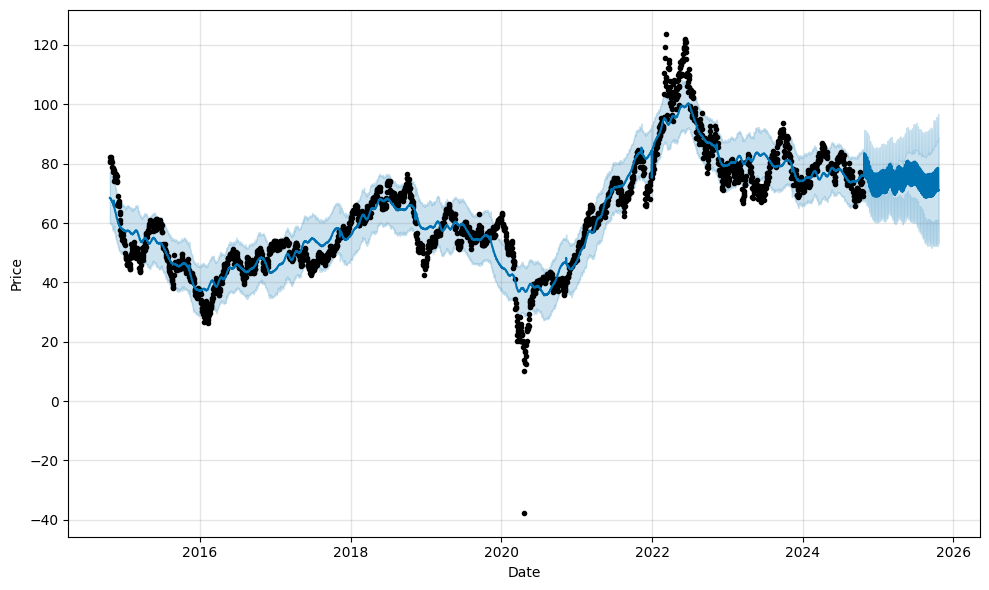

In [12]:
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Price')

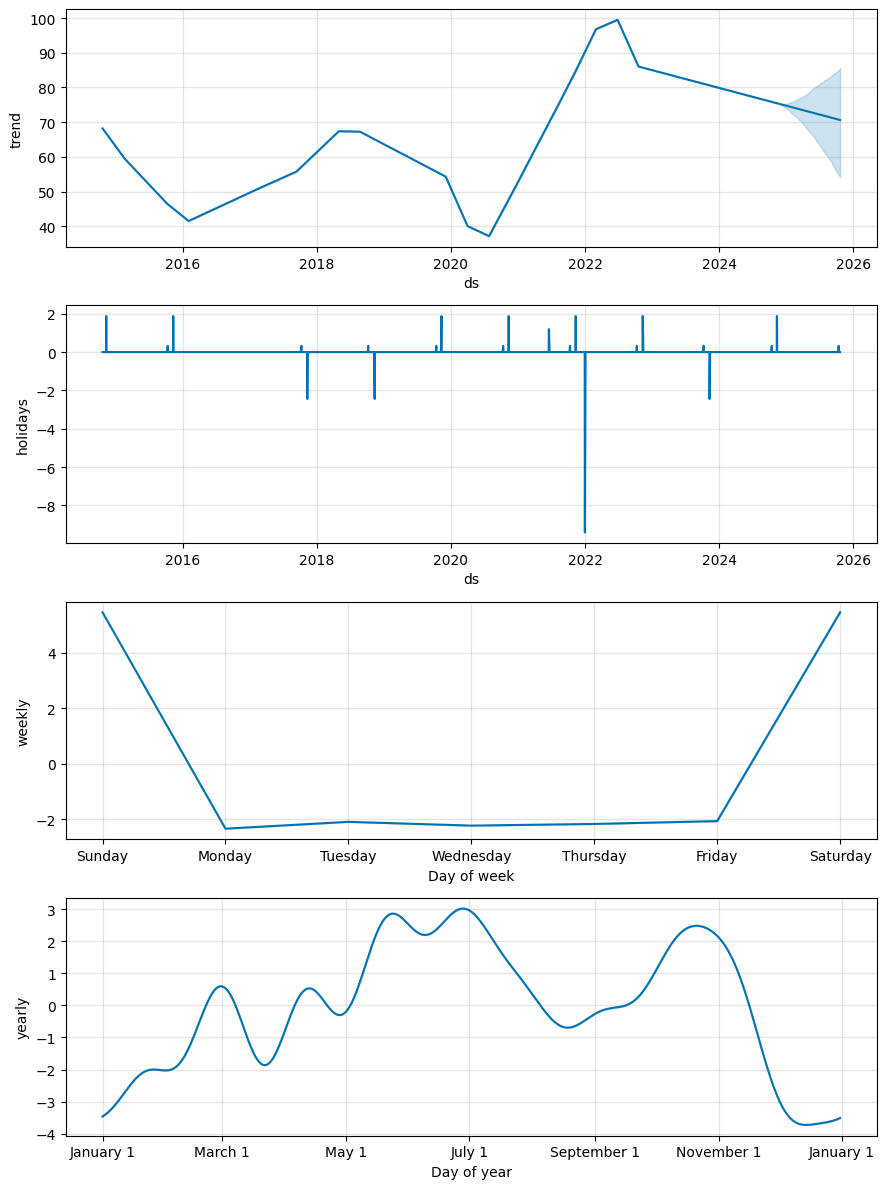

In [13]:
figure2 = m.plot_components(forecast)

## Hyperparameter Tuning

In [16]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:55:27 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  16.649056
1                     0.001                     0.10  16.949996
2                     0.001                     1.00  17.010021
3                     0.001                    10.00  16.970648
4                     0.010                     0.01  13.918657
5                     0.010                     0.10  14.089489
6                     0.010                     1.00  14.113670
7                     0.010                    10.00  14.103117
8                     0.100                     0.01  11.771180
9                     0.100                     0.10  11.950697
10                    0.100                     1.00  11.957690
11                    0.100                    10.00  11.960386
12                    0.500                     0.01  11.432190
13                    0.500                     0.10  11.779718
14                    0.500             

16:02:55 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
best_params = all_params[np.argmin(rmses)]
print(best_params)
m = Prophet(**best_params).fit(data_prophet_df)  # Fit model with best params

16:05:19 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


16:05:20 - cmdstanpy - INFO - Chain [1] done processing


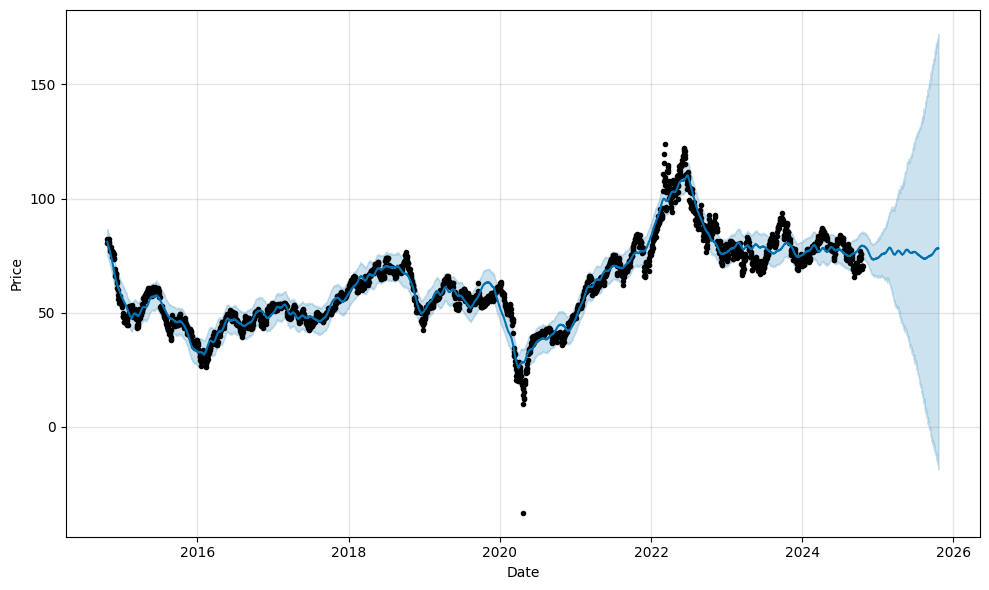

In [18]:
# Forcasting into the future
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Price')

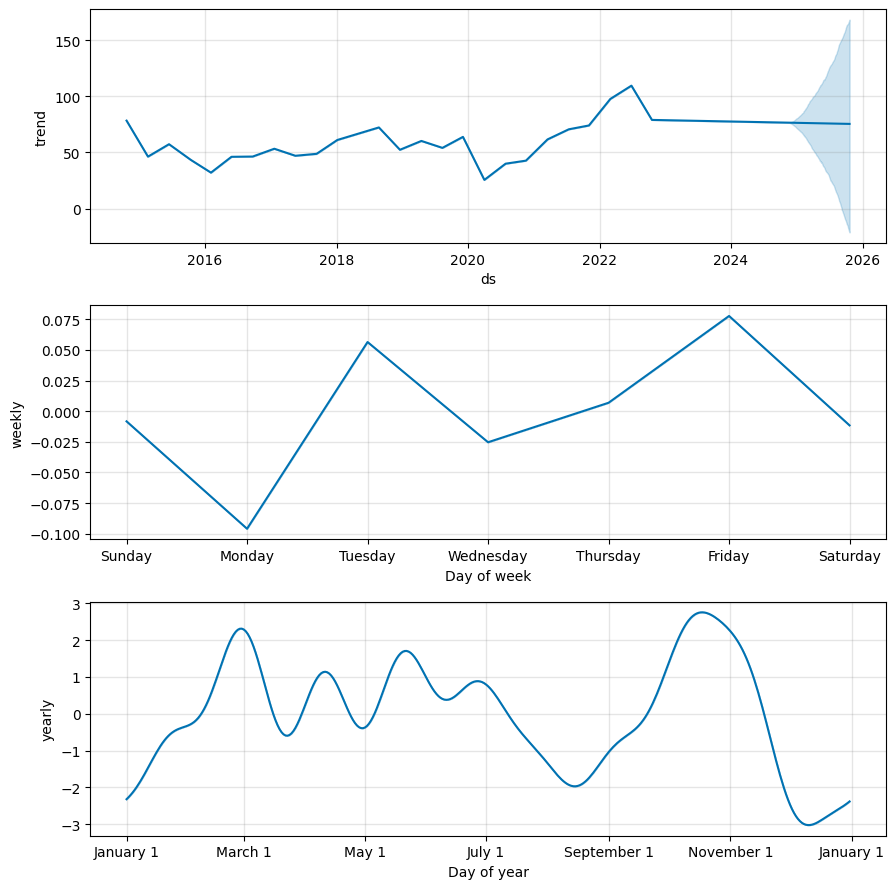

In [19]:
figure2 = m.plot_components(forecast)